We start with uploading our data.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from mpl_toolkits.mplot3d import Axes3D

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/SolarPrediction.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


It is visible, that both Data and Time include time, so let's check, wheter the first one needs it.

In [115]:
data_time_part = pd.to_datetime(df['Data'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce').dt.time
print(data_time_part.unique())

[datetime.time(0, 0)]


That means, that each data has 12:00:00 AM, which is meaningless. Let's then create a more useful column - DateTime.

We also can calculate the daylength, which may be helpful for us.

In [116]:
data_part = pd.to_datetime(df['Data'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce').dt.date
df['DateTime'] = pd.to_datetime(data_part.astype(str) + " " + df['Time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
print(df[['Data','Time','DateTime']].head())
sunrise_dt = pd.to_datetime(df['TimeSunRise'], format="%H:%M:%S")
sunset_dt  = pd.to_datetime(df['TimeSunSet'],  format="%H:%M:%S")
df['DayLength'] = (sunset_dt - sunrise_dt).dt.total_seconds()
df[['TimeSunRise','TimeSunSet','DayLength']].head()

                    Data      Time            DateTime
0  9/29/2016 12:00:00 AM  23:55:26 2016-09-29 23:55:26
1  9/29/2016 12:00:00 AM  23:50:23 2016-09-29 23:50:23
2  9/29/2016 12:00:00 AM  23:45:26 2016-09-29 23:45:26
3  9/29/2016 12:00:00 AM  23:40:21 2016-09-29 23:40:21
4  9/29/2016 12:00:00 AM  23:35:24 2016-09-29 23:35:24


,TimeSunRise,TimeSunSet,DayLength
0,06:13:00,18:13:00,43200.0
1,06:13:00,18:13:00,43200.0
2,06:13:00,18:13:00,43200.0
3,06:13:00,18:13:00,43200.0
4,06:13:00,18:13:00,43200.0


Now let's move on to regression. We will investigate Radiation dependence on different parameters

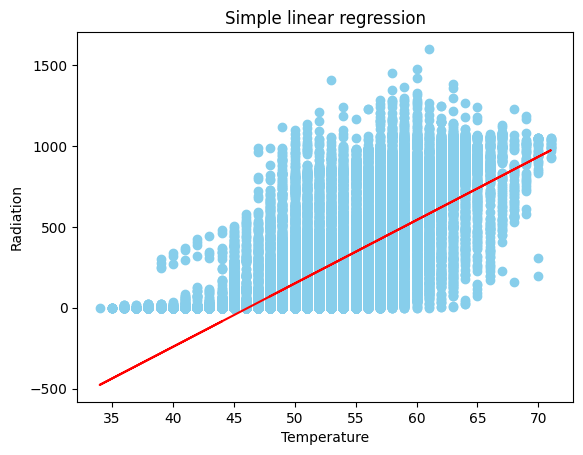

In [117]:
X_temp=df.Temperature.values.reshape(-1,1)
y=df.Radiation.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)
plt.scatter(X_temp, y, color='skyblue')           # original data
plt.plot(X_temp, model.predict(X_temp), color='red') # regression line
plt.title("Simple linear regression")
plt.xlabel("Temperature")
plt.ylabel("Radiation")
plt.show()

Let's also try polynomial transformation

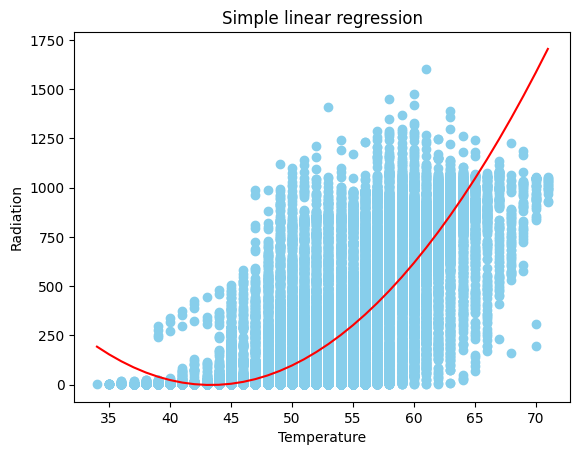

In [118]:
#we have to sort our data
df_sorted=df.sort_values(by='Temperature')
X_temp=df_sorted.Temperature.values.reshape(-1,1)
y=df_sorted.Radiation.values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, shuffle=False)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_temp_poly = poly.transform(X_temp)
#scaling
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_temp_poly_scaled = scaler.transform(X_temp_poly)
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)
plt.scatter(X_temp, y, color='skyblue')           # original data
plt.plot(X_temp, model.predict(X_temp_poly_scaled), color='red') # regression line
plt.title("Simple linear regression")
plt.xlabel("Temperature")
plt.ylabel("Radiation")
plt.show()

Let's check, how degree affects the error:

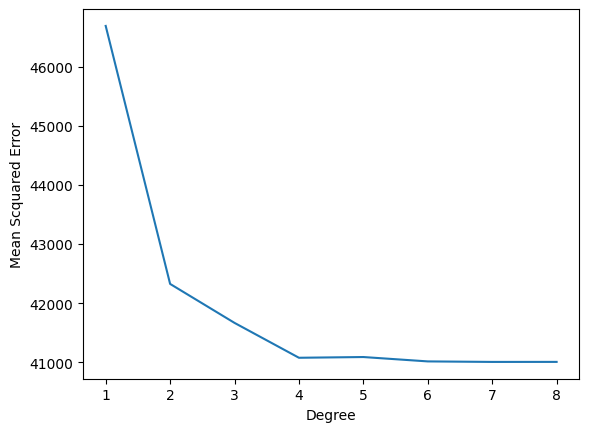

In [119]:
mse=[]
degrees=[]
for degree in range(1, 9):
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=44)
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    scaler = StandardScaler()
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)
    X_test_poly_scaled = scaler.transform(X_test_poly)
    model = LinearRegression()
    model.fit(X_train_poly_scaled, y_train)
    y_pred = model.predict(X_test_poly_scaled)
    mse.append(mean_squared_error(y_test, y_pred))
    degrees.append(degree)
plt.plot(degrees, mse)
plt.xlabel("Degree")
plt.ylabel("Mean Scquared Error")
plt.show()


We see, that with the increase of degree, the error descreases.

Let's now find other dependencies and approximate them (I used different degrees for each one):

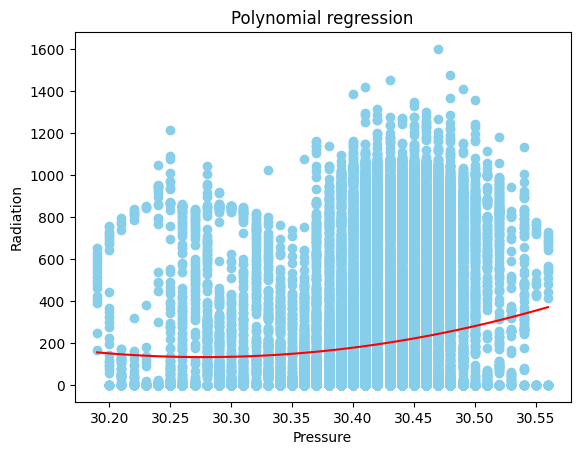

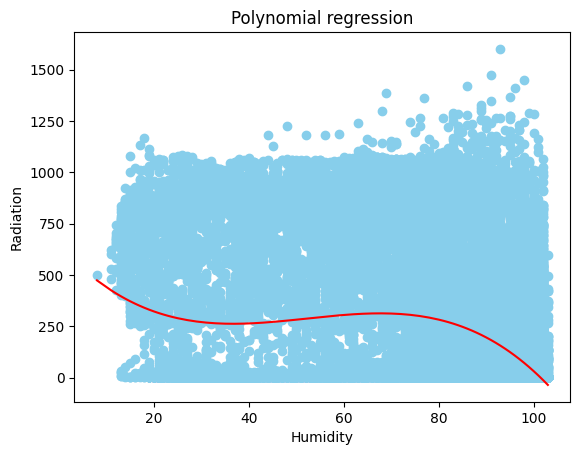

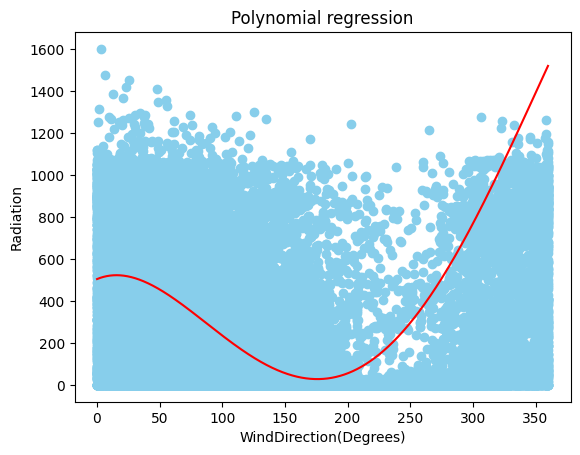

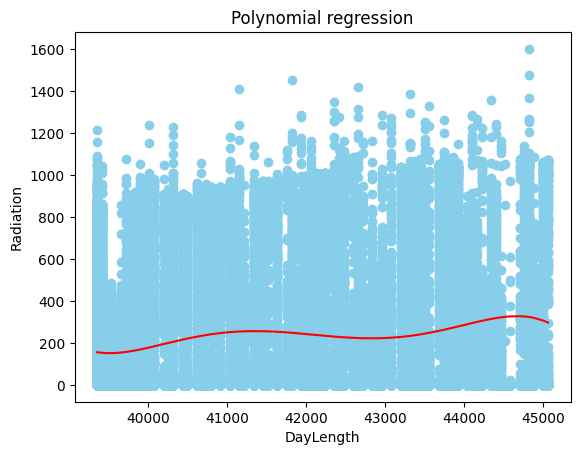

In [120]:
#Pressure
df_sorted=df.sort_values(by='Pressure')
X_pres=df_sorted.Pressure.values.reshape(-1,1)
y=df_sorted.Radiation.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_pres, y, test_size=0.2, shuffle=False)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_pres_poly = poly.transform(X_pres)
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_pres_poly_scaled = scaler.transform(X_pres_poly)
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)
plt.scatter(X_pres, y, color='skyblue')           # original data
plt.plot(X_pres, model.predict(X_pres_poly_scaled), color='red') # regression line
plt.title("Polynomial regression")
plt.xlabel("Pressure")
plt.ylabel("Radiation")
plt.show()


#Humidity
df_sorted=df.sort_values(by='Humidity')
X_hum=df_sorted.Humidity.values.reshape(-1,1)
y=df_sorted.Radiation.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_hum, y, test_size=0.2, shuffle=False)
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_hum_poly = poly.transform(X_hum)
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_hum_poly_scaled = scaler.transform(X_hum_poly)
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)
plt.scatter(X_hum, y, color='skyblue')           # original data
plt.plot(X_hum, model.predict(X_hum_poly_scaled), color='red') # regression line
plt.title("Polynomial regression")
plt.xlabel("Humidity")
plt.ylabel("Radiation")
plt.show()


#WindDirection
df_sorted=df.sort_values(by='WindDirection(Degrees)')
X_wind=df_sorted['WindDirection(Degrees)'].values.reshape(-1,1)
y=df_sorted.Radiation.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_wind, y, test_size=0.2, shuffle=False)
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_wind_poly = poly.transform(X_wind)
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_wind_poly_scaled = scaler.transform(X_wind_poly)
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)
plt.scatter(X_wind, y, color='skyblue')           # original data
plt.plot(X_wind, model.predict(X_wind_poly_scaled), color='red') # regression line
plt.title("Polynomial regression")
plt.xlabel("WindDirection(Degrees)")
plt.ylabel("Radiation")
plt.show()


#DayLength
df_sorted=df.sort_values(by='DayLength')
X_day=df_sorted.DayLength.values.reshape(-1,1)
y=df_sorted.Radiation.values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X_day, y, test_size=0.2, shuffle=False)
poly = PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train)
X_day_poly = poly.transform(X_day)
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_day_poly_scaled = scaler.transform(X_day_poly)
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)
plt.scatter(X_day, y, color='skyblue')           # original data
plt.plot(X_day, model.predict(X_day_poly_scaled), color='red') # regression line
plt.title("Polynomial regression")
plt.xlabel("DayLength")
plt.ylabel("Radiation")
plt.show()

We see, that radiation is affected by each one. Let's find how those parameters are related to each other.
We pick multiple features to give the model a full picture of what affects radiation: weather conditions and time patterns.

Text(0.5, 1.0, 'Radiation by Temp & Humidity')

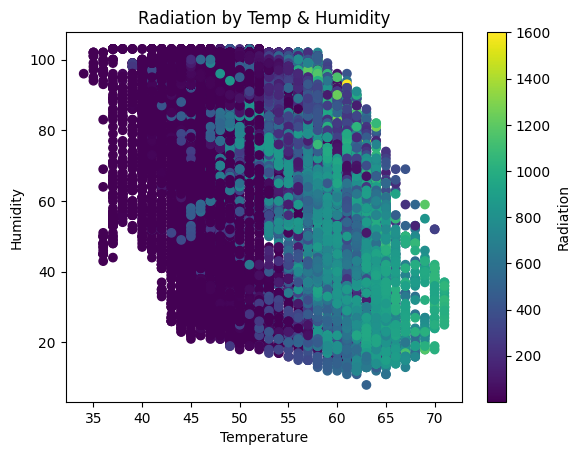

In [122]:
plt.scatter(df['Temperature'], df['Humidity'], c=df['Radiation'])
plt.xlabel("Temperature")
plt.ylabel("Humidity")
plt.colorbar(label="Radiation")
plt.title("Radiation by Temp & Humidity")

We see, that radiation increases with the increase of temperature and decrease of humidity, so let's try to describe it.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


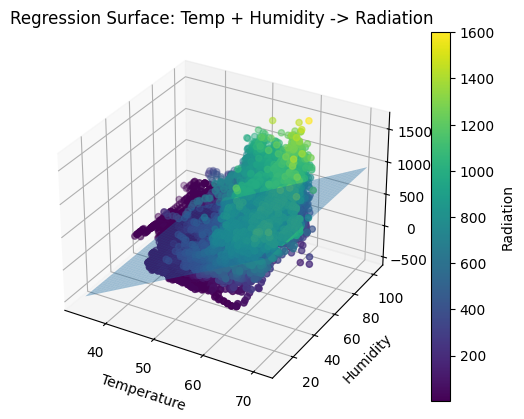

In [124]:
X = df[['Temperature','Humidity']]
y = df['Radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)

# сreate grid for surface
temp_grid = np.linspace(df['Temperature'].min(), df['Temperature'].max(), 40)
hum_grid = np.linspace(df['Humidity'].min(), df['Humidity'].max(), 40)
tt, hh = np.meshgrid(temp_grid, hum_grid)

# flatten the grid to feed into model.predict
grid = np.column_stack((tt.ravel(), hh.ravel()))
rr = model.predict(grid).reshape(tt.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# scatter points colored by radiation
scatter= ax.scatter(df['Temperature'], df['Humidity'], df['Radiation'], c=df['Radiation'])

# regression surface
ax.plot_surface(tt, hh, rr, alpha=0.4)

ax.set_xlabel("Temperature")
ax.set_ylabel("Humidity")
ax.set_zlabel("Radiation")
ax.set_title("Regression Surface: Temp + Humidity -> Radiation")
fig.colorbar(scatter, ax=ax, label="Radiation")
plt.show()


Let's do the same for different pair of parameters:

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


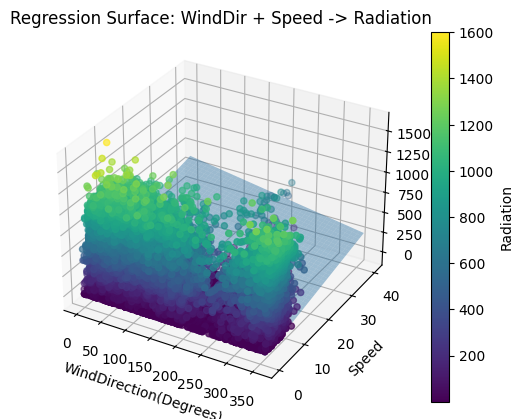

In [125]:
X = df[['WindDirection(Degrees)','Speed']]
y = df['Radiation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)

# сreate grid for surface
temp_grid = np.linspace(df['WindDirection(Degrees)'].min(), df['WindDirection(Degrees)'].max(), 40)
hum_grid = np.linspace(df['Speed'].min(), df['Speed'].max(), 40)
tt, hh = np.meshgrid(temp_grid, hum_grid)

# flatten the grid to feed into model.predict
grid = np.column_stack((tt.ravel(), hh.ravel()))
rr = model.predict(grid).reshape(tt.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# scatter points colored by radiation
scatter= ax.scatter(df['WindDirection(Degrees)'], df['Speed'], df['Radiation'], c=df['Radiation'])

# regression surface
ax.plot_surface(tt, hh, rr, alpha=0.4)

ax.set_xlabel("WindDirection(Degrees)")
ax.set_ylabel("Speed")
ax.set_zlabel("Radiation")
ax.set_title("Regression Surface: WindDir + Speed -> Radiation")
fig.colorbar(scatter, ax=ax, label="Radiation")
plt.show()


I also was curious about trying Polynomial Regression for this case , so that our prediction is not a plane.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


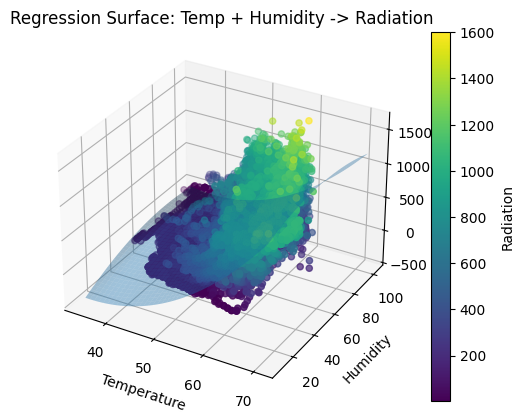

In [127]:
X = df[['Temperature','Humidity']]
y = df['Radiation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_poly=poly.transform(X)
model = LinearRegression()
model.fit(X_train_poly, y_train)

# сreate grid for surface
temp_grid = np.linspace(df['Temperature'].min(), df['Temperature'].max(), 40)
hum_grid = np.linspace(df['Humidity'].min(), df['Humidity'].max(), 40)
tt, hh = np.meshgrid(temp_grid, hum_grid)

# for the grid
grid = np.column_stack((tt.ravel(), hh.ravel()))
grid_poly = poly.transform(grid)
rr_poly = model.predict(grid_poly).reshape(tt.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# scatter points colored by radiation
scatter= ax.scatter(df['Temperature'], df['Humidity'], df['Radiation'], c=df['Radiation'])

# regression surface
ax.plot_surface(tt, hh, rr_poly, alpha=0.4)

ax.set_xlabel("Temperature")
ax.set_ylabel("Humidity")
ax.set_zlabel("Radiation")
ax.set_title("Regression Surface: Temp + Humidity -> Radiation")
fig.colorbar(scatter, ax=ax, label="Radiation")
plt.show()


The last thing I was curious about was the mdoel with several features and error, that it has:

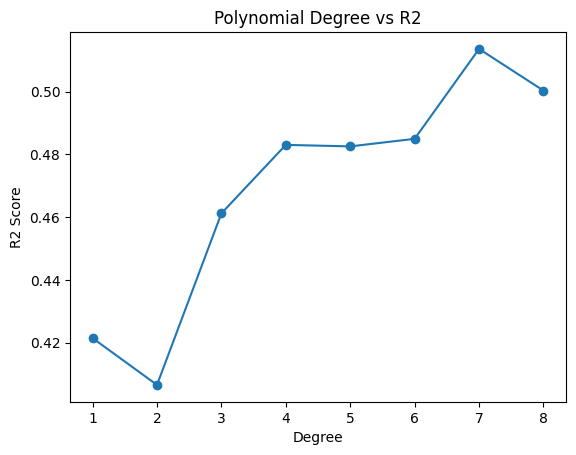

R2 per degree: [0.4214114023294049, 0.40648522015027755, 0.46118209089391216, 0.48302044028919566, 0.48253631608014647, 0.48494875842730234, 0.5136128617814286, 0.5003132937944266]


In [132]:
features = ['Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed','DayLength']
target = 'Radiation'
X=df[features]
y=df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
r2 = []
degrees = range(1, 9)
for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly  = poly.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)
    r2.append(r2_score(y_test, y_pred))

plt.figure()
plt.plot(degrees, r2, marker='o')
plt.xlabel("Degree")
plt.ylabel("R2 Score")
plt.title("Polynomial Degree vs R2")
plt.show()

print("R2 per degree:", r2)

We see very interesting dependece - optimal degree for R2 Score is 2.